## *Importing The Libraries*

In [1]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

import keras # high level api to tensorflow (or theano, CNTK, etc.) and useful image preprocessing
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 4.8.1
Keras image data format: channels_last


In [3]:
def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

### Background Subtraction Techniques

#### Using a background image to find differences (can be used for images and video)

This technique requires a background image to find the difference between the background and the current frame to find what as changed. This difference creates a 'mask' that represents where in the image the foreground is. A draw back of this algorithm is that any movement of the camera, change of lighting, change in focus, etc. will make the current frame totally different from the background image.

The algorithm:
* load in the background image and the current frame
* find the absolute difference between the images
* create a mask that contains a 'map' of pixels that should be 'on or off'
* apply the mask to the current frame to extract the foreground by iterating over each pixel and copying all pixels from the current frame that should be part of the foreground

### CNN

Below is the picture which gives a simplistic idea of CNN.

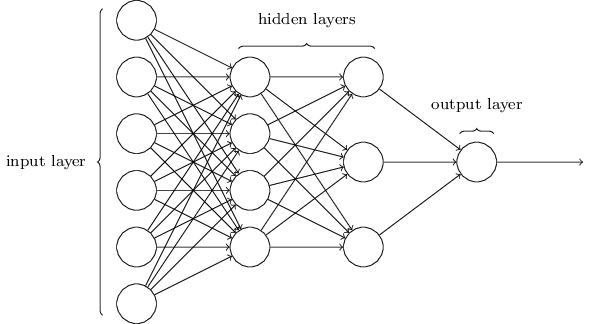

In [22]:
show_image("neuralnetwork.png")

Here we build our neural network and compile it with a loss function and optimizers of our choice.

## Deep into Convoltuional Neural Network

"Regular" neural networks are less effective when working with images as every pixel is considered separately when calculating probabilities. This means that a normal fully-connected neural network is not good at classifying images, for example, if the object moves in the scene.

Convolutional layers learn to look for *features* that are found in an image of certain classes. This is useful because it means that early on in a computation the model is not looking for specific *things* but rather simpler features like edges and corners.

To look for these features, the convolutional layers learn *filters* that are applied accross the image using a sliding window. This window finds how similair the filter being applied and the region of the image is.

Early in the computation, the filters are looking for edges and corners, then evenutally uses these edges and corners to look for higher and higher level features. By the end of the computation, filters are being learned to look for very high level features.

After features are extracted by the convolutional layers, this high level data is fed into a regular neural network which learns which features correspond to which outputs.

Each convolutional layer also has pooling layer which keeps the important information intact and decreases the spatial dimension. The model is then connected to a flattened layer with 128 units where upon then connected to 3 units (Final 3 classes) with softmax function since it is a multiclass problem.

### Collecting data

The next objective is to recognize which gesture a hand is posed in. We will train our neural network on 3 gestures: fist, five, and swing. For this network we will train the network on the mask to reduce dimensionality. Doing this makes it a more simple problem for the network to model, while sacrificing information stored in the colours of an image.

Here, we track our hand with the background subtracted and thresholded. Everytime you hit 's' a screen capture of your cropped hand is saved. To reset the background frame press 'r'.

In [5]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

CURR_POSE = 'swing'
DATA = 'validation_data'

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Text display positions
positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20)
}


# Image count for file name
img_count = 0

# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        img_count += 1
        fname = r"C:\Users\blvis\DATA\validation\class0\fist_{}.jpg".format(img_count)
        print(fname)
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [109]:
import cv2

# Define the path to the saved image
image_path = r"C:\Users\blvis\DATA1\train\class0\fist_06.jpg"

# Read the image
image = cv2.imread(image_path)

# Check if the image was successfully loaded
if image is not None:
    # Display the image
    cv2.imshow("Saved Image", image)
    cv2.waitKey(0)  # Wait until any key is pressed
    cv2.destroyAllWindows()
else:
    print(f"Could not read the image at {image_path}")


### Image Augmentation

Here after collecting the dataset we expand the size much further by augmentation. we introdue varitey of augmentations like horizontal shift, vertical shift, horizontal flip, shearing, rotaion etc. The user can select what set of images need to be augmented and the amaount of imges to be produced.

In [ ]:
import os
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Define the directory of the images
image_dir = r"C:\Users\blvis\DATA1\train\class0"

# List of image filenames to process
image_filenames = ['fist_0_4.jpeg', 'fist_0_55.jpeg', 'fist_0_473.jpeg']

# Initialize ImageDataGenerator for augmentation
training_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Process each image
for image_filename in image_filenames:
    # Load the image
    img_path = os.path.join(image_dir, image_filename)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Apply data augmentation and save the images
    i = 0
    for batch in training_datagen.flow(x, batch_size=1,
                                      save_to_dir=r'C:\Users\blvis\DATA1\validation\class0',
                                      save_prefix='fist', save_format='jpeg'):
        i += 1
        if i > 100:
            break


### Preparing Data for Training

Here we use the keras data generator to augment data. This loads data and applies certain transformations to it in order to improve generalization of the model.

The ImageDataGenerator.flow_from_directory() is a convenience method that prepares classification data according to file directories.

Training data is used to train the model to recognize gestures and validation data is used to verify that the model is not over fitting to the training data and the network is converging.

In [151]:
batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)
print(os.getcwd())

training_generator = training_datagen.flow_from_directory(
    r"C:\Users\blvis\DATA1\train",
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    r'C:\Users\blvis\DATA1\validation',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True
)
test_generator = validation_datagen.flow_from_directory(
    r'C:\Users\blvis\test',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False
)

C:\Users\blvis
Found 2592 images belonging to 3 classes.
Found 897 images belonging to 3 classes.
Found 897 images belonging to 3 classes.


In [118]:
train_data = training_generator
train_labels = training_generator.classes
validation_data = validation_generator
validation_labels = validation_generator.classes

In [119]:
train_labels

array([0, 0, 0, ..., 2, 2, 2])

### Amount of training data used in each class

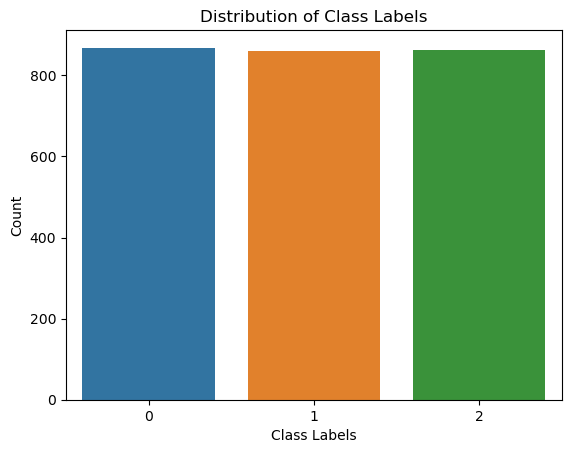

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming class_labels is a numpy array or list of class labels
sns.countplot(x=train_labels)

# Add labels and title
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')

# Show the plot
plt.show()


### Generating Labels For The Test Data

In [159]:
classt_labels = test_generator.classes


In [160]:
print(classt_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

### Sample

Below cell produces a sample of images showing the effect of training_datagen in the dataset.

In [10]:
img = load_img(r"C:\Users\blvis\DATA\train\class1\five_1.jpg")  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in training_datagen.flow(x, batch_size=1,
                          save_to_dir=r'C:\Users\blvis\preview\five', save_prefix='fist', save_format='jpeg'):
    i += 1
    if i > 1000:
        break

### Building the Neural Network

Here we assemble the neural network with keras and compile it for training.

This is a very simple convolutional neural network containing three convolutional and max pooling layers. After a tensor is passed through the convolutional layers, it is flatted into a vector and passed through the dense layers.

In [125]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(3))
model.add(Activation('softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 52, 52, 64)        640       
                                                                 
 activation_40 (Activation)  (None, 52, 52, 64)        0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 26, 26, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 activation_41 (Activation)  (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                

## Training the model

In [126]:
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler

# Train the model and store the training history
history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2500 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=600 // batch_size,
    shuffle=True  # Shuffle data at the beginning of each epoch
)

Epoch 1/50


C:\Users\blvis\AppData\Local\Temp\ipykernel_2728\2241780086.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


156/156 [==============================] - 10s 57ms/step - loss: 2.1743 - accuracy: 0.4764 - val_loss: 0.7824 - val_accuracy: 0.6318
Epoch 2/50
156/156 [==============================] - 10s 65ms/step - loss: 0.7667 - accuracy: 0.6550 - val_loss: 0.4811 - val_accuracy: 0.7973
Epoch 3/50
156/156 [==============================] - 11s 68ms/step - loss: 0.5374 - accuracy: 0.7712 - val_loss: 0.2884 - val_accuracy: 0.8885
Epoch 4/50
156/156 [==============================] - 10s 66ms/step - loss: 0.4743 - accuracy: 0.8077 - val_loss: 0.2848 - val_accuracy: 0.8970
Epoch 5/50
156/156 [==============================] - 11s 70ms/step - loss: 0.3609 - accuracy: 0.8558 - val_loss: 0.1556 - val_accuracy: 0.9611
Epoch 6/50
156/156 [==============================] - 11s 69ms/step - loss: 0.2968 - accuracy: 0.8918 - val_loss: 0.1529 - val_accuracy: 0.9595
Epoch 7/50
156/156 [==============================] - 11s 67ms/step - loss: 0.2353 - accuracy: 0.9195 - val_loss: 0.0836 - val_accuracy: 0.9730
Epo

### Plot The Training And Validation Accuracy

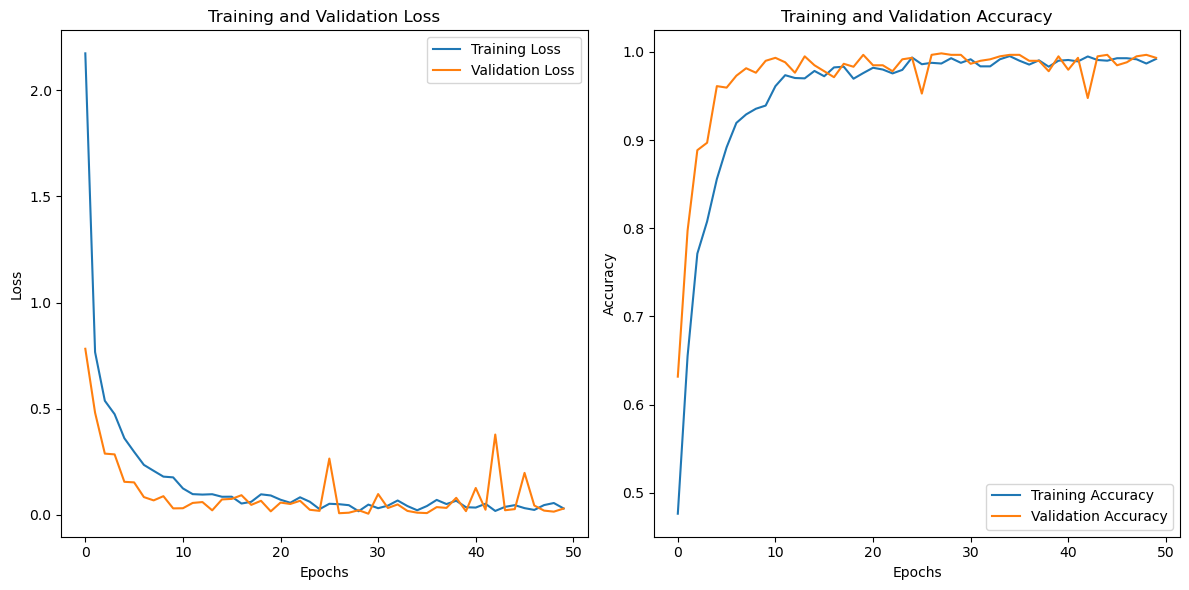

In [127]:
# Get the training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



### Testing The Model With The Test Data

In [154]:
test_generator.reset()
test_steps = len(test_generator)
test_accuracy = model.predict_generator(test_generator, steps=test_steps, workers=8)



C:\Users\blvis\AppData\Local\Temp\ipykernel_2728\2583027193.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_accuracy = model.predict_generator(test_generator, steps=test_steps, workers=8)


In [155]:
predicted_classes = np.argmax(test_accuracy, axis=1)

In [166]:
y_pred = predicted_classes


Accuracy Score:
 0.992196209587514
Classification Report:
              precision    recall  f1-score   support

      class0       0.98      1.00      0.99       298
      class1       1.00      1.00      1.00       296
      class2       1.00      0.98      0.99       303

    accuracy                           0.99       897
   macro avg       0.99      0.99      0.99       897
weighted avg       0.99      0.99      0.99       897



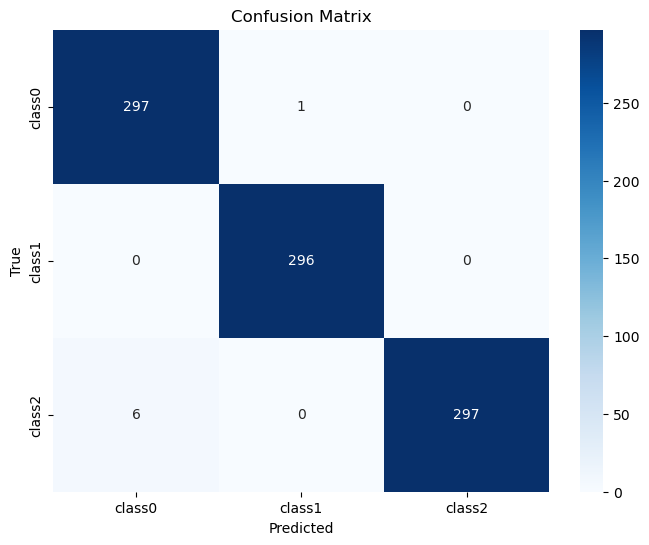

In [167]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score
# Get class names
class_names = list(test_generator.class_indices.keys())
print('\nAccuracy Score:\n', accuracy_score(classt_labels, y_pred))
# Generate classification report
report = classification_report(classt_labels, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Generate confusion matrix
confusion_mtx = confusion_matrix(classt_labels, y_pred)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Saving the model

In [169]:
#'model' is our trained model
model.save('my_model_final.hdf5')

### Loading the model

In [4]:
from tensorflow.keras.models import load_model

# Load the model
hand_model = load_model(r"C:\Users\blvis\my_model_final.hdf5", compile=False)

### Running The Model With Real Time Frame Capture

The below cell also shows accuracy of each frame being classified. it can be removed if there is decrease in frame rate or incraease in delay it can be quit pressing 'ESC'. To reset the fram and threshold press 'R'.

In [5]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'swing'
}

# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Display positions (pixel coordinates)
positions = {
    'hand_pose': (15, 40), # hand pose text
    'fps': (15, 20), # fps counter
    'null_pos': (200, 200) # used as null point for mouse control
}


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (116, 116, 170, 170) # Starting position for bounding box
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8) # Black screen to display data
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        # Resize cropped hand and make prediction on gesture
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = hand_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() # Get the index of the greatest confidence
        gesture = classes[predi]
        
        for i, pred in enumerate(prediction[0]):
            # Draw confidence bar for each gesture
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx # calculate length of confidence bar
            
            # Make the most confidence prediction green
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
            
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
    
    # Move the mouse
    hand_pos = ((p1[0] + p2[0])//2, (p1[1] + p2[1])//2)
    mouse_change = ((p1[0] + p2[0])//2 - positions['null_pos'][0], positions['null_pos'][0] - (p1[1] + p2[1])//2)
    # Draw mouse points
    cv2.circle(display, positions['null_pos'], 5, (0,0,255), -1)
    cv2.circle(display, hand_pos, 5, (0,255,0), -1)
    cv2.line(display,positions['null_pos'],hand_pos,(255,0,0),5)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display result
    cv2.imshow("data", data_display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 108: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


### With Model Simmulation in blender
Make sure you install pyserial library in Blender software also make the necessary setups including COM port and baud rate of 115200. 
### Some info
Press 'r' to reset the frame and 'Esc' to quit the model.
### Working
The below model works in the following way:

Class 0: Fist: Pause

Class 1: Five: Forward (0.05) Increment (Y-axis)

Class 2: Swing: Backward (0.05) Decrement (Y-axis)

In [9]:
import serial
import time
import random

# Define the serial port and baud rate
ser = serial.Serial('COM1', 115200)  # Adjust 'COM3' with your specific port

# Define the initial axis values
x1 = 0
y1 = 0
z1 = 0
x2 = 0
y2 = 0
z2 = 0
x3 = 0
y3 = 0
z3 = 0

# Function to generate random meaningful words
def generate_random_text(length):
    words = ["a"]
    return ' '.join(words)

# Function to generate the current axis values
def generate_current_axis():
    return f"{x1},{y1},{z1},{x2},{y2},{z2},{x3},{y3},{z3}"

# Function to send data to Blender
def send_to_blender():
    text_data = generate_random_text(3)
    movement_data = generate_current_axis()
    send_data = f"{movement_data};{text_data}\n"
    ser.write(send_data.encode())
    print(f"Sent data: {send_data.strip()}")

classes = {
    0: 'fist',
    1: 'five',
    2: 'swing'
}

# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Display positions (pixel coordinates)
positions = {
    'hand_pose': (15, 40), # hand pose text
    'fps': (15, 20), # fps counter
    'null_pos': (200, 200) # used as null point for mouse control
}


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (116, 116, 170, 170) # Starting position for bounding box
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8) # Black screen to display data
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        # Resize cropped hand and make prediction on gesture
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = hand_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() # Get the index of the greatest confidence
        gesture = classes[predi]
        
        # Blender control
        if gesture == 'five':
            y1 += 0.05 #move the obstacle forward in Y axis
            send_to_blender()
        elif gesture == 'swing':
            y1 -= 0.05 #move the obstacle backward in Y axis
            send_to_blender()
        elif gesture == 'fist':
            pass #pause the movement
        
        for i, pred in enumerate(prediction[0]):
            # Draw confidence bar for each gesture
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx # calculate length of confidence bar
            
            # Make the most confidence prediction green
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
            
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
    
    # Move the mouse
    hand_pos = ((p1[0] + p2[0])//2, (p1[1] + p2[1])//2)
    mouse_change = ((p1[0] + p2[0])//2 - positions['null_pos'][0], positions['null_pos'][0] - (p1[1] + p2[1])//2)
    # Draw mouse points
    cv2.circle(display, positions['null_pos'], 5, (0,0,255), -1)
    cv2.circle(display, hand_pos, 5, (0,255,0), -1)
    cv2.line(display,positions['null_pos'],hand_pos,(255,0,0),5)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display result
    cv2.imshow("data", data_display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 108: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

1/1 [==============================] - 2s 2s/step
Sent data: 0,0.05,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 54ms/step
Sent data: 0,0.1,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 38ms/step
Sent data: 0,0.15000000000000002,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 34ms/step
Sent data: 0,0.2,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 33ms/step
Sent data: 0,0.25,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 31ms/step
Sent data: 0,0.3,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 30ms/step
Sent data: 0,0.35,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 33ms/step
Sent data: 0,0.39999999999999997,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 31ms/step
Sent data: 0,0.44999999999999996,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 34ms/step
Sent data: 0,0.49999999999999994,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 40ms/step
Sent data: 0,0.5499999999999999,0

1/1 [==============================] - 0s 33ms/step
Sent data: 0,0.7000000000000001,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 30ms/step
Sent data: 0,0.7500000000000001,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 48ms/step
Sent data: 0,0.8000000000000002,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 47ms/step
Sent data: 0,0.8500000000000002,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 51ms/step
Sent data: 0,0.9000000000000002,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 57ms/step
Sent data: 0,0.9500000000000003,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 53ms/step
Sent data: 0,1.0000000000000002,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 52ms/step
Sent data: 0,1.0500000000000003,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 44ms/step
Sent data: 0,1.1000000000000003,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 43ms/step
Sent data: 0,1.1500000000000004,0,0,0,0,0,0,0;a


1/1 [==============================] - 0s 36ms/step
Sent data: 0,2.4499999999999993,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 44ms/step
Sent data: 0,2.3999999999999995,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 44ms/step
Sent data: 0,2.3499999999999996,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 37ms/step
Sent data: 0,2.3,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 36ms/step
Sent data: 0,2.25,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 42ms/step
Sent data: 0,2.2,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 41ms/step
Sent data: 0,2.1500000000000004,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 41ms/step
Sent data: 0,2.1000000000000005,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 41ms/step
Sent data: 0,2.0500000000000007,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 47ms/step
Sent data: 0,2.000000000000001,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 37m

Sent data: 0,1.5000000000000004,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 45ms/step
Sent data: 0,1.5500000000000005,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 40ms/step
Sent data: 0,1.6000000000000005,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 40ms/step
Sent data: 0,1.6500000000000006,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 39ms/step
Sent data: 0,1.7000000000000006,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 48ms/step
Sent data: 0,1.7500000000000007,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 46ms/step
Sent data: 0,1.8000000000000007,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 50ms/step
Sent data: 0,1.8500000000000008,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 50ms/step
Sent data: 0,1.9000000000000008,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 43ms/step
Sent data: 0,1.9500000000000008,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 39ms/step
Sent data: 0,2.5999999999999988,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 43ms/step
Sent data: 0,2.549999999999999,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 40ms/step
Sent data: 0,2.499999999999999,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 42ms/step
Sent data: 0,2.4499999999999993,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 40ms/step
Sent data: 0,2.3999999999999995,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 35ms/step
Sent data: 0,2.3499999999999996,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 38ms/step
Sent data: 0,2.3,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 38ms/step
Sent data: 0,2.25,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 36ms/step
Sent data: 0,2.2,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 44ms/step
Sent data: 0,2.1500000000000004,0,0,0,0,0,0,0;a
1/1 [==============================] - 0s 42ms

In [46]:
cv2.destroyAllWindows()
video.release()